In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import random
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl

from pong.pong import games_generator
from pong.renderer import Renderer

from matplotlib import cm

tf.enable_eager_execution()

In [4]:
get_game = games_generator(40, 40, 256, 0.85)

In [5]:
_, (frame, _) = next(get_game)

(40, 40)

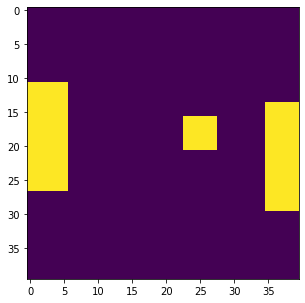

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(frame[120])
frame[120].shape

In [6]:
directions = []
controls = []
frames = []
done = []

for _ in tqdm(range(4000)):
    (d, c), (f, go) = next(get_game)
    directions.append(d)
    controls.append(c)
    frames.append(f)
    done.append(go)

directions = np.array(directions)
controls = np.array(controls)
frames = np.array(frames)
done = np.array(done)

directions.shape, controls.shape, frames.shape, done.shape

((4000,), (4000, 256, 2), (4000, 256, 40, 40), (4000, 256))

In [7]:
only_frames = frames.reshape((-1, 40, 40))
only_frames.shape

(1024000, 40, 40)

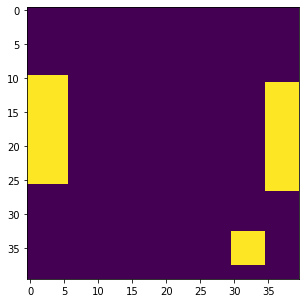

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(only_frames[98548])

In [9]:
i = tf.keras.layers.Input((40, 40), name='input')
e = i
e = tf.keras.layers.Reshape((40, 40, 1))(e)
e = tf.keras.layers.Conv2D(32, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(64, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(128, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Reshape((3 * 3 * 128,), name='flatten')(e)
e = tf.keras.layers.Dense(32)(e)

d = e
d = tf.keras.layers.Dense(1024)(d)
d = tf.keras.layers.Reshape((1, 1, 1024))(d)
d = tf.keras.layers.Conv2DTranspose(128, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(64, (5, 5), activation='relu', strides=1)(d)
d = tf.keras.layers.Conv2DTranspose(32, (5, 5), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(1, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Reshape((40, 40), name='frame')(d)

net = tf.keras.Model(i, d)

net.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mse', 'accuracy']
)

In [10]:
encoder = tf.keras.Model(i, e)

In [11]:
decode_input = tf.keras.layers.Input((32,))
out = decode_input
for l in net.layers[7:]:
    out = l(out)
    
decoder = tf.keras.Model(decode_input, out)

In [12]:
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 40, 40)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 19, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         131200    
_________________________________________________________________
flatten (Reshape)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                36896 

In [13]:
net.fit(
    x=only_frames,
    y=only_frames,
    batch_size=128
)

1024000/1024000 [==============================] - 77s 75us/sample - loss: 0.0016 - mean_squared_error: 0.0016 - acc: 0.4609


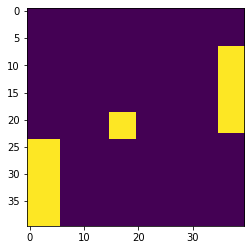

In [14]:
plt.imshow(only_frames[9000])

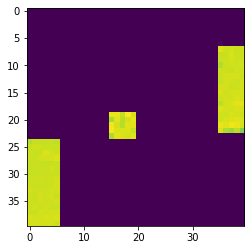

In [15]:
pred_f = net.predict(only_frames[9000].reshape(1, 40, 40)).reshape(40, 40)
plt.imshow(pred_f)

In [16]:
encoded_frames = []
for f in tqdm(frames):
    encoded_frames.append(encoder.predict(f))
        
encoded_frames = np.array(encoded_frames)
encoded_frames.shape

(4000, 256, 32)

In [17]:
class Memory:
    def __init__(self, stateful=False):
        bs = 1 if stateful else None

        init_dir = tf.keras.Input((1,), batch_size=bs)
        user_input = tf.keras.Input((None, 2), batch_size=bs)

        self.dir_hidden = tf.keras.layers.Dense(256)
        self.dir_cell_state = tf.keras.layers.Dense(256)
        self.lstm_input = tf.keras.layers.Dense(32)

        self.lstm = tf.keras.layers.GRU(
            256,
            return_sequences=True,
            stateful=stateful,
            name='lstm'
        )

        self.done_logits = tf.keras.layers.Dense(1)
        self.frame_logits1 = tf.keras.layers.Dense(128)
        self.frame_logits2 = tf.keras.layers.Dense(32)
        
        dh = self.dir_hidden(init_dir)
        dcs = self.dir_cell_state(init_dir)
        li = self.lstm_input(user_input)
        l = self.lstm(li, initial_state=[dh])
        dl = self.done_logits(l)
        fl = self.frame_logits2(self.frame_logits1(l))

        self.net = tf.keras.Model([init_dir, user_input], [fl, dl])
        self.net.compile(
            loss='mse',
            optimizer='adam',
            metrics=['accuracy', 'mse']
        )

    def init(self, direction):
        self.direction = direction
        self.first_time = True

    def step(self, user_input):
        user_input = np.array([[user_input]])
        user_input = tf.convert_to_tensor(user_input, dtype=tf.float32)

        direction = np.array([[self.direction]])
        direction = tf.convert_to_tensor(direction, dtype=tf.float32)

        li = self.lstm_input(user_input)

        if self.first_time:
            self.first_time = False
            dh = self.dir_hidden(direction)
            dcs = self.dir_cell_state(direction)
            l = self.lstm(li, initial_state=[dh])
        else:
            l = self.lstm(li)

        dl = self.done_logits(l)
        fl = self.frame_logits2(self.frame_logits1(l))

        return fl[0].numpy(), dl[0].numpy()
    
    def copy_in_stateful_model(self):
        stateful = Memory(stateful=True)
        for nb, layer in enumerate(self.net.layers):
            stateful.net.layers[nb].set_weights(layer.get_weights())
        return stateful

In [18]:
memory = Memory()
memory.net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, None, 32)     96          input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          512         input_2[0][0]                    
____________________________________________________________________________________________

In [19]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
memory.net.fit(
    x=[directions.reshape(-1, 1), controls[:, 1:]],
    y=[encoded_frames[:, :-1], np.expand_dims(done[:, :-1], -1)],
    validation_split=0.1,
    batch_size=128,
    epochs=1000,
    callbacks=[tensorboard_callback]
)

Train on 3600 samples, validate on 400 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1000
3600/3600 [==============================] - 37s 10ms/sample - loss: 0.8781 - dense_7_loss: 0.5766 - dense_5_loss: 0.2992 - dense_7_acc: 0.3127 - dense_7_mean_squared_error: 0.5769 - dense_5_acc: 0.5759 - dense_5_mean_squared_error: 0.3012 - val_loss: 0.7587 - val_dense_7_loss: 0.5440 - val_dense_5_loss: 0.2187 - val_dense_7_acc: 0.3819 - val_dense_7_mean_squared_error: 0.5405 - val_dense_5_acc: 0.6869 - val_dense_5_mean_squared_error: 0.2182
Epoch 2/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.7491 - dense_7_loss: 0.5463 - dense_5_loss: 0.2005 - dense_7_acc: 0.3754 - dense_7_mean_squared_error: 0.5480 - dense_5_acc: 0.7098 - dense_5_mean_squared_error: 0.2011 - val_loss: 0.6927 - val_dense_7_loss: 0.5218 - val_dense_5_loss: 0.1591 - val_dense_7_acc: 0.3816 - val_dense_7_mean_squared_error: 0.5321 - val_d

Epoch 18/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.6211 - dense_7_loss: 0.4611 - dense_5_loss: 0.1611 - dense_7_acc: 0.3978 - dense_7_mean_squared_error: 0.4601 - dense_5_acc: 0.7722 - dense_5_mean_squared_error: 0.1610 - val_loss: 0.5978 - val_dense_7_loss: 0.4426 - val_dense_5_loss: 0.1502 - val_dense_7_acc: 0.4064 - val_dense_7_mean_squared_error: 0.4434 - val_dense_5_acc: 0.7778 - val_dense_5_mean_squared_error: 0.1544
Epoch 19/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.6037 - dense_7_loss: 0.4495 - dense_5_loss: 0.1573 - dense_7_acc: 0.4063 - dense_7_mean_squared_error: 0.4470 - dense_5_acc: 0.7728 - dense_5_mean_squared_error: 0.1567 - val_loss: 0.5983 - val_dense_7_loss: 0.4398 - val_dense_5_loss: 0.1628 - val_dense_7_acc: 0.3947 - val_dense_7_mean_squared_error: 0.4401 - val_dense_5_acc: 0.7794 - val_dense_5_mean_squared_error: 0.1582
Epoch 20/1000
3600/3600 [==============================] - 32s 9ms/sample - loss

Epoch 36/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.5075 - dense_7_loss: 0.3880 - dense_5_loss: 0.1185 - dense_7_acc: 0.4230 - dense_7_mean_squared_error: 0.3888 - dense_5_acc: 0.8291 - dense_5_mean_squared_error: 0.1187 - val_loss: 0.5081 - val_dense_7_loss: 0.3758 - val_dense_5_loss: 0.1187 - val_dense_7_acc: 0.4281 - val_dense_7_mean_squared_error: 0.3825 - val_dense_5_acc: 0.8095 - val_dense_5_mean_squared_error: 0.1256
Epoch 37/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.4958 - dense_7_loss: 0.3769 - dense_5_loss: 0.1179 - dense_7_acc: 0.4296 - dense_7_mean_squared_error: 0.3782 - dense_5_acc: 0.8291 - dense_5_mean_squared_error: 0.1176 - val_loss: 0.4881 - val_dense_7_loss: 0.3743 - val_dense_5_loss: 0.1122 - val_dense_7_acc: 0.4289 - val_dense_7_mean_squared_error: 0.3733 - val_dense_5_acc: 0.8314 - val_dense_5_mean_squared_error: 0.1147
Epoch 38/1000
3600/3600 [==============================] - 31s 9ms/sample - loss

Epoch 54/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.4406 - dense_7_loss: 0.3327 - dense_5_loss: 0.1057 - dense_7_acc: 0.4606 - dense_7_mean_squared_error: 0.3341 - dense_5_acc: 0.8476 - dense_5_mean_squared_error: 0.1065 - val_loss: 0.4472 - val_dense_7_loss: 0.3589 - val_dense_5_loss: 0.1134 - val_dense_7_acc: 0.4567 - val_dense_7_mean_squared_error: 0.3377 - val_dense_5_acc: 0.8409 - val_dense_5_mean_squared_error: 0.1095
Epoch 55/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.4174 - dense_7_loss: 0.3195 - dense_5_loss: 0.0994 - dense_7_acc: 0.4751 - dense_7_mean_squared_error: 0.3183 - dense_5_acc: 0.8585 - dense_5_mean_squared_error: 0.0991 - val_loss: 0.4485 - val_dense_7_loss: 0.3381 - val_dense_5_loss: 0.1130 - val_dense_7_acc: 0.4577 - val_dense_7_mean_squared_error: 0.3361 - val_dense_5_acc: 0.8359 - val_dense_5_mean_squared_error: 0.1124
Epoch 56/1000
3600/3600 [==============================] - 31s 9ms/sample - loss

Epoch 72/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.3650 - dense_7_loss: 0.2841 - dense_5_loss: 0.0802 - dense_7_acc: 0.5007 - dense_7_mean_squared_error: 0.2841 - dense_5_acc: 0.8884 - dense_5_mean_squared_error: 0.0809 - val_loss: 0.4207 - val_dense_7_loss: 0.3162 - val_dense_5_loss: 0.0936 - val_dense_7_acc: 0.4638 - val_dense_7_mean_squared_error: 0.3184 - val_dense_5_acc: 0.8531 - val_dense_5_mean_squared_error: 0.1023
Epoch 73/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.3690 - dense_7_loss: 0.2873 - dense_5_loss: 0.0822 - dense_7_acc: 0.4974 - dense_7_mean_squared_error: 0.2867 - dense_5_acc: 0.8853 - dense_5_mean_squared_error: 0.0822 - val_loss: 0.4213 - val_dense_7_loss: 0.3112 - val_dense_5_loss: 0.1041 - val_dense_7_acc: 0.4677 - val_dense_7_mean_squared_error: 0.3150 - val_dense_5_acc: 0.8481 - val_dense_5_mean_squared_error: 0.1063
Epoch 74/1000
3600/3600 [==============================] - 31s 9ms/sample - loss

Epoch 90/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.3151 - dense_7_loss: 0.2527 - dense_5_loss: 0.0616 - dense_7_acc: 0.5296 - dense_7_mean_squared_error: 0.2529 - dense_5_acc: 0.9161 - dense_5_mean_squared_error: 0.0623 - val_loss: 0.4272 - val_dense_7_loss: 0.3126 - val_dense_5_loss: 0.1068 - val_dense_7_acc: 0.4786 - val_dense_7_mean_squared_error: 0.3169 - val_dense_5_acc: 0.8417 - val_dense_5_mean_squared_error: 0.1103
Epoch 91/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.3297 - dense_7_loss: 0.2645 - dense_5_loss: 0.0669 - dense_7_acc: 0.5203 - dense_7_mean_squared_error: 0.2633 - dense_5_acc: 0.9111 - dense_5_mean_squared_error: 0.0665 - val_loss: 0.4126 - val_dense_7_loss: 0.3135 - val_dense_5_loss: 0.1225 - val_dense_7_acc: 0.4810 - val_dense_7_mean_squared_error: 0.3077 - val_dense_5_acc: 0.8549 - val_dense_5_mean_squared_error: 0.1050
Epoch 92/1000
3600/3600 [==============================] - 31s 8ms/sample - loss

Epoch 108/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.2852 - dense_7_loss: 0.2348 - dense_5_loss: 0.0502 - dense_7_acc: 0.5407 - dense_7_mean_squared_error: 0.2349 - dense_5_acc: 0.9345 - dense_5_mean_squared_error: 0.0503 - val_loss: 0.4639 - val_dense_7_loss: 0.3622 - val_dense_5_loss: 0.1249 - val_dense_7_acc: 0.4446 - val_dense_7_mean_squared_error: 0.3433 - val_dense_5_acc: 0.8390 - val_dense_5_mean_squared_error: 0.1206
Epoch 109/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.3416 - dense_7_loss: 0.2749 - dense_5_loss: 0.0667 - dense_7_acc: 0.5091 - dense_7_mean_squared_error: 0.2749 - dense_5_acc: 0.9128 - dense_5_mean_squared_error: 0.0667 - val_loss: 0.4337 - val_dense_7_loss: 0.3330 - val_dense_5_loss: 0.1167 - val_dense_7_acc: 0.4579 - val_dense_7_mean_squared_error: 0.3212 - val_dense_5_acc: 0.8454 - val_dense_5_mean_squared_error: 0.1124
Epoch 110/1000
3600/3600 [==============================] - 31s 8ms/sample - l

Epoch 126/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.2555 - dense_7_loss: 0.2139 - dense_5_loss: 0.0430 - dense_7_acc: 0.5609 - dense_7_mean_squared_error: 0.2135 - dense_5_acc: 0.9462 - dense_5_mean_squared_error: 0.0420 - val_loss: 0.4311 - val_dense_7_loss: 0.3152 - val_dense_5_loss: 0.1156 - val_dense_7_acc: 0.4812 - val_dense_7_mean_squared_error: 0.3136 - val_dense_5_acc: 0.8443 - val_dense_5_mean_squared_error: 0.1175
Epoch 127/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.2494 - dense_7_loss: 0.2097 - dense_5_loss: 0.0402 - dense_7_acc: 0.5642 - dense_7_mean_squared_error: 0.2092 - dense_5_acc: 0.9484 - dense_5_mean_squared_error: 0.0402 - val_loss: 0.4239 - val_dense_7_loss: 0.3056 - val_dense_5_loss: 0.1068 - val_dense_7_acc: 0.4766 - val_dense_7_mean_squared_error: 0.3129 - val_dense_5_acc: 0.8541 - val_dense_5_mean_squared_error: 0.1110
Epoch 128/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 144/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2298 - dense_7_loss: 0.1963 - dense_5_loss: 0.0328 - dense_7_acc: 0.5725 - dense_7_mean_squared_error: 0.1966 - dense_5_acc: 0.9580 - dense_5_mean_squared_error: 0.0332 - val_loss: 0.4252 - val_dense_7_loss: 0.3127 - val_dense_5_loss: 0.0982 - val_dense_7_acc: 0.4846 - val_dense_7_mean_squared_error: 0.3148 - val_dense_5_acc: 0.8589 - val_dense_5_mean_squared_error: 0.1104
Epoch 145/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.2279 - dense_7_loss: 0.1939 - dense_5_loss: 0.0323 - dense_7_acc: 0.5794 - dense_7_mean_squared_error: 0.1955 - dense_5_acc: 0.9596 - dense_5_mean_squared_error: 0.0324 - val_loss: 0.4465 - val_dense_7_loss: 0.3196 - val_dense_5_loss: 0.1169 - val_dense_7_acc: 0.4721 - val_dense_7_mean_squared_error: 0.3257 - val_dense_5_acc: 0.8428 - val_dense_5_mean_squared_error: 0.1207
Epoch 146/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 162/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2136 - dense_7_loss: 0.1852 - dense_5_loss: 0.0287 - dense_7_acc: 0.5938 - dense_7_mean_squared_error: 0.1847 - dense_5_acc: 0.9638 - dense_5_mean_squared_error: 0.0289 - val_loss: 0.4461 - val_dense_7_loss: 0.3317 - val_dense_5_loss: 0.1339 - val_dense_7_acc: 0.4707 - val_dense_7_mean_squared_error: 0.3241 - val_dense_5_acc: 0.8483 - val_dense_5_mean_squared_error: 0.1220
Epoch 163/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2041 - dense_7_loss: 0.1764 - dense_5_loss: 0.0257 - dense_7_acc: 0.5938 - dense_7_mean_squared_error: 0.1780 - dense_5_acc: 0.9678 - dense_5_mean_squared_error: 0.0260 - val_loss: 0.4415 - val_dense_7_loss: 0.3329 - val_dense_5_loss: 0.1161 - val_dense_7_acc: 0.4894 - val_dense_7_mean_squared_error: 0.3210 - val_dense_5_acc: 0.8496 - val_dense_5_mean_squared_error: 0.1205
Epoch 164/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 180/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2171 - dense_7_loss: 0.1865 - dense_5_loss: 0.0312 - dense_7_acc: 0.5876 - dense_7_mean_squared_error: 0.1859 - dense_5_acc: 0.9605 - dense_5_mean_squared_error: 0.0312 - val_loss: 0.4455 - val_dense_7_loss: 0.3362 - val_dense_5_loss: 0.1205 - val_dense_7_acc: 0.4887 - val_dense_7_mean_squared_error: 0.3256 - val_dense_5_acc: 0.8480 - val_dense_5_mean_squared_error: 0.1200
Epoch 181/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2078 - dense_7_loss: 0.1790 - dense_5_loss: 0.0271 - dense_7_acc: 0.5894 - dense_7_mean_squared_error: 0.1809 - dense_5_acc: 0.9664 - dense_5_mean_squared_error: 0.0270 - val_loss: 0.4501 - val_dense_7_loss: 0.3586 - val_dense_5_loss: 0.1532 - val_dense_7_acc: 0.4729 - val_dense_7_mean_squared_error: 0.3290 - val_dense_5_acc: 0.8478 - val_dense_5_mean_squared_error: 0.1211
Epoch 182/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 198/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1885 - dense_7_loss: 0.1650 - dense_5_loss: 0.0233 - dense_7_acc: 0.6088 - dense_7_mean_squared_error: 0.1649 - dense_5_acc: 0.9707 - dense_5_mean_squared_error: 0.0236 - val_loss: 0.4669 - val_dense_7_loss: 0.3457 - val_dense_5_loss: 0.1263 - val_dense_7_acc: 0.4754 - val_dense_7_mean_squared_error: 0.3392 - val_dense_5_acc: 0.8473 - val_dense_5_mean_squared_error: 0.1277
Epoch 199/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1904 - dense_7_loss: 0.1684 - dense_5_loss: 0.0226 - dense_7_acc: 0.6103 - dense_7_mean_squared_error: 0.1676 - dense_5_acc: 0.9718 - dense_5_mean_squared_error: 0.0228 - val_loss: 0.4497 - val_dense_7_loss: 0.3191 - val_dense_5_loss: 0.1237 - val_dense_7_acc: 0.4729 - val_dense_7_mean_squared_error: 0.3296 - val_dense_5_acc: 0.8527 - val_dense_5_mean_squared_error: 0.1201
Epoch 200/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 216/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1716 - dense_7_loss: 0.1529 - dense_5_loss: 0.0183 - dense_7_acc: 0.6237 - dense_7_mean_squared_error: 0.1531 - dense_5_acc: 0.9777 - dense_5_mean_squared_error: 0.0185 - val_loss: 0.4463 - val_dense_7_loss: 0.3320 - val_dense_5_loss: 0.1236 - val_dense_7_acc: 0.4907 - val_dense_7_mean_squared_error: 0.3256 - val_dense_5_acc: 0.8571 - val_dense_5_mean_squared_error: 0.1207
Epoch 217/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1657 - dense_7_loss: 0.1482 - dense_5_loss: 0.0174 - dense_7_acc: 0.6343 - dense_7_mean_squared_error: 0.1484 - dense_5_acc: 0.9797 - dense_5_mean_squared_error: 0.0172 - val_loss: 0.4501 - val_dense_7_loss: 0.3238 - val_dense_5_loss: 0.1172 - val_dense_7_acc: 0.4893 - val_dense_7_mean_squared_error: 0.3282 - val_dense_5_acc: 0.8558 - val_dense_5_mean_squared_error: 0.1219
Epoch 218/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 234/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1586 - dense_7_loss: 0.1413 - dense_5_loss: 0.0167 - dense_7_acc: 0.6439 - dense_7_mean_squared_error: 0.1419 - dense_5_acc: 0.9799 - dense_5_mean_squared_error: 0.0168 - val_loss: 0.4515 - val_dense_7_loss: 0.2995 - val_dense_5_loss: 0.1092 - val_dense_7_acc: 0.4807 - val_dense_7_mean_squared_error: 0.3273 - val_dense_5_acc: 0.8565 - val_dense_5_mean_squared_error: 0.1242
Epoch 235/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1582 - dense_7_loss: 0.1412 - dense_5_loss: 0.0162 - dense_7_acc: 0.6458 - dense_7_mean_squared_error: 0.1418 - dense_5_acc: 0.9802 - dense_5_mean_squared_error: 0.0164 - val_loss: 0.4631 - val_dense_7_loss: 0.3426 - val_dense_5_loss: 0.1364 - val_dense_7_acc: 0.4965 - val_dense_7_mean_squared_error: 0.3366 - val_dense_5_acc: 0.8513 - val_dense_5_mean_squared_error: 0.1265
Epoch 236/1000
3600/3600 [==============================] - 31s 8ms/sample - l

Epoch 252/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1724 - dense_7_loss: 0.1523 - dense_5_loss: 0.0197 - dense_7_acc: 0.6272 - dense_7_mean_squared_error: 0.1529 - dense_5_acc: 0.9764 - dense_5_mean_squared_error: 0.0196 - val_loss: 0.4435 - val_dense_7_loss: 0.3126 - val_dense_5_loss: 0.1118 - val_dense_7_acc: 0.4946 - val_dense_7_mean_squared_error: 0.3286 - val_dense_5_acc: 0.8593 - val_dense_5_mean_squared_error: 0.1149
Epoch 253/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1607 - dense_7_loss: 0.1453 - dense_5_loss: 0.0183 - dense_7_acc: 0.6406 - dense_7_mean_squared_error: 0.1435 - dense_5_acc: 0.9795 - dense_5_mean_squared_error: 0.0172 - val_loss: 0.4409 - val_dense_7_loss: 0.3107 - val_dense_5_loss: 0.1077 - val_dense_7_acc: 0.4883 - val_dense_7_mean_squared_error: 0.3276 - val_dense_5_acc: 0.8611 - val_dense_5_mean_squared_error: 0.1134
Epoch 254/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 270/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1409 - dense_7_loss: 0.1281 - dense_5_loss: 0.0125 - dense_7_acc: 0.6674 - dense_7_mean_squared_error: 0.1284 - dense_5_acc: 0.9855 - dense_5_mean_squared_error: 0.0126 - val_loss: 0.4602 - val_dense_7_loss: 0.3646 - val_dense_5_loss: 0.1445 - val_dense_7_acc: 0.5011 - val_dense_7_mean_squared_error: 0.3365 - val_dense_5_acc: 0.8586 - val_dense_5_mean_squared_error: 0.1237
Epoch 271/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.1428 - dense_7_loss: 0.1315 - dense_5_loss: 0.0137 - dense_7_acc: 0.6625 - dense_7_mean_squared_error: 0.1294 - dense_5_acc: 0.9843 - dense_5_mean_squared_error: 0.0134 - val_loss: 0.4660 - val_dense_7_loss: 0.2977 - val_dense_5_loss: 0.1132 - val_dense_7_acc: 0.4919 - val_dense_7_mean_squared_error: 0.3374 - val_dense_5_acc: 0.8510 - val_dense_5_mean_squared_error: 0.1286
Epoch 272/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 288/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1442 - dense_7_loss: 0.1314 - dense_5_loss: 0.0137 - dense_7_acc: 0.6590 - dense_7_mean_squared_error: 0.1303 - dense_5_acc: 0.9834 - dense_5_mean_squared_error: 0.0139 - val_loss: 0.4721 - val_dense_7_loss: 0.3531 - val_dense_5_loss: 0.1212 - val_dense_7_acc: 0.4985 - val_dense_7_mean_squared_error: 0.3472 - val_dense_5_acc: 0.8587 - val_dense_5_mean_squared_error: 0.1249
Epoch 289/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1410 - dense_7_loss: 0.1271 - dense_5_loss: 0.0134 - dense_7_acc: 0.6663 - dense_7_mean_squared_error: 0.1278 - dense_5_acc: 0.9844 - dense_5_mean_squared_error: 0.0133 - val_loss: 0.4719 - val_dense_7_loss: 0.3426 - val_dense_5_loss: 0.1233 - val_dense_7_acc: 0.4894 - val_dense_7_mean_squared_error: 0.3429 - val_dense_5_acc: 0.8511 - val_dense_5_mean_squared_error: 0.1289
Epoch 290/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 306/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2308 - dense_7_loss: 0.1921 - dense_5_loss: 0.0366 - dense_7_acc: 0.5778 - dense_7_mean_squared_error: 0.1938 - dense_5_acc: 0.9528 - dense_5_mean_squared_error: 0.0370 - val_loss: 0.4610 - val_dense_7_loss: 0.3738 - val_dense_5_loss: 0.1272 - val_dense_7_acc: 0.4792 - val_dense_7_mean_squared_error: 0.3401 - val_dense_5_acc: 0.8497 - val_dense_5_mean_squared_error: 0.1209
Epoch 307/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1786 - dense_7_loss: 0.1586 - dense_5_loss: 0.0220 - dense_7_acc: 0.6232 - dense_7_mean_squared_error: 0.1568 - dense_5_acc: 0.9729 - dense_5_mean_squared_error: 0.0218 - val_loss: 0.4478 - val_dense_7_loss: 0.3182 - val_dense_5_loss: 0.1120 - val_dense_7_acc: 0.4842 - val_dense_7_mean_squared_error: 0.3336 - val_dense_5_acc: 0.8593 - val_dense_5_mean_squared_error: 0.1142
Epoch 308/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 324/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1739 - dense_7_loss: 0.1541 - dense_5_loss: 0.0206 - dense_7_acc: 0.6272 - dense_7_mean_squared_error: 0.1532 - dense_5_acc: 0.9747 - dense_5_mean_squared_error: 0.0207 - val_loss: 0.4583 - val_dense_7_loss: 0.3382 - val_dense_5_loss: 0.1346 - val_dense_7_acc: 0.4856 - val_dense_7_mean_squared_error: 0.3355 - val_dense_5_acc: 0.8480 - val_dense_5_mean_squared_error: 0.1229
Epoch 325/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1548 - dense_7_loss: 0.1375 - dense_5_loss: 0.0162 - dense_7_acc: 0.6456 - dense_7_mean_squared_error: 0.1383 - dense_5_acc: 0.9798 - dense_5_mean_squared_error: 0.0165 - val_loss: 0.4540 - val_dense_7_loss: 0.3217 - val_dense_5_loss: 0.1155 - val_dense_7_acc: 0.4847 - val_dense_7_mean_squared_error: 0.3334 - val_dense_5_acc: 0.8541 - val_dense_5_mean_squared_error: 0.1206
Epoch 326/1000
3600/3600 [==============================] - 31s 8ms/sample - l

Epoch 342/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1203 - dense_7_loss: 0.1109 - dense_5_loss: 0.0092 - dense_7_acc: 0.6956 - dense_7_mean_squared_error: 0.1111 - dense_5_acc: 0.9896 - dense_5_mean_squared_error: 0.0091 - val_loss: 0.4556 - val_dense_7_loss: 0.3634 - val_dense_5_loss: 0.1444 - val_dense_7_acc: 0.5016 - val_dense_7_mean_squared_error: 0.3342 - val_dense_5_acc: 0.8634 - val_dense_5_mean_squared_error: 0.1214
Epoch 343/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1227 - dense_7_loss: 0.1147 - dense_5_loss: 0.0099 - dense_7_acc: 0.6929 - dense_7_mean_squared_error: 0.1130 - dense_5_acc: 0.9888 - dense_5_mean_squared_error: 0.0097 - val_loss: 0.4566 - val_dense_7_loss: 0.3490 - val_dense_5_loss: 0.1362 - val_dense_7_acc: 0.4950 - val_dense_7_mean_squared_error: 0.3356 - val_dense_5_acc: 0.8624 - val_dense_5_mean_squared_error: 0.1211
Epoch 344/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 360/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2858 - dense_7_loss: 0.2294 - dense_5_loss: 0.0539 - dense_7_acc: 0.5467 - dense_7_mean_squared_error: 0.2312 - dense_5_acc: 0.9300 - dense_5_mean_squared_error: 0.0546 - val_loss: 0.4500 - val_dense_7_loss: 0.3327 - val_dense_5_loss: 0.1175 - val_dense_7_acc: 0.4573 - val_dense_7_mean_squared_error: 0.3372 - val_dense_5_acc: 0.8563 - val_dense_5_mean_squared_error: 0.1128
Epoch 361/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.1935 - dense_7_loss: 0.1672 - dense_5_loss: 0.0252 - dense_7_acc: 0.6074 - dense_7_mean_squared_error: 0.1679 - dense_5_acc: 0.9678 - dense_5_mean_squared_error: 0.0255 - val_loss: 0.4563 - val_dense_7_loss: 0.3193 - val_dense_5_loss: 0.0993 - val_dense_7_acc: 0.4659 - val_dense_7_mean_squared_error: 0.3440 - val_dense_5_acc: 0.8614 - val_dense_5_mean_squared_error: 0.1123
Epoch 362/1000
3600/3600 [==============================] - 31s 8ms/sample - l

Epoch 378/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1236 - dense_7_loss: 0.1146 - dense_5_loss: 0.0104 - dense_7_acc: 0.6864 - dense_7_mean_squared_error: 0.1135 - dense_5_acc: 0.9882 - dense_5_mean_squared_error: 0.0101 - val_loss: 0.4493 - val_dense_7_loss: 0.3614 - val_dense_5_loss: 0.1359 - val_dense_7_acc: 0.5026 - val_dense_7_mean_squared_error: 0.3316 - val_dense_5_acc: 0.8654 - val_dense_5_mean_squared_error: 0.1177
Epoch 379/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.1211 - dense_7_loss: 0.1128 - dense_5_loss: 0.0094 - dense_7_acc: 0.6922 - dense_7_mean_squared_error: 0.1116 - dense_5_acc: 0.9891 - dense_5_mean_squared_error: 0.0094 - val_loss: 0.4470 - val_dense_7_loss: 0.3264 - val_dense_5_loss: 0.1309 - val_dense_7_acc: 0.4989 - val_dense_7_mean_squared_error: 0.3265 - val_dense_5_acc: 0.8638 - val_dense_5_mean_squared_error: 0.1205
Epoch 380/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 396/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1697 - dense_7_loss: 0.1480 - dense_5_loss: 0.0208 - dense_7_acc: 0.6310 - dense_7_mean_squared_error: 0.1485 - dense_5_acc: 0.9736 - dense_5_mean_squared_error: 0.0212 - val_loss: 0.4400 - val_dense_7_loss: 0.3341 - val_dense_5_loss: 0.1115 - val_dense_7_acc: 0.4855 - val_dense_7_mean_squared_error: 0.3239 - val_dense_5_acc: 0.8558 - val_dense_5_mean_squared_error: 0.1161
Epoch 397/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1461 - dense_7_loss: 0.1345 - dense_5_loss: 0.0157 - dense_7_acc: 0.6557 - dense_7_mean_squared_error: 0.1311 - dense_5_acc: 0.9821 - dense_5_mean_squared_error: 0.0150 - val_loss: 0.4472 - val_dense_7_loss: 0.3372 - val_dense_5_loss: 0.1296 - val_dense_7_acc: 0.4912 - val_dense_7_mean_squared_error: 0.3245 - val_dense_5_acc: 0.8546 - val_dense_5_mean_squared_error: 0.1227
Epoch 398/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 414/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.2148 - dense_7_loss: 0.1805 - dense_5_loss: 0.0363 - dense_7_acc: 0.6083 - dense_7_mean_squared_error: 0.1790 - dense_5_acc: 0.9549 - dense_5_mean_squared_error: 0.0358 - val_loss: 0.4784 - val_dense_7_loss: 0.3369 - val_dense_5_loss: 0.1317 - val_dense_7_acc: 0.4730 - val_dense_7_mean_squared_error: 0.3516 - val_dense_5_acc: 0.8441 - val_dense_5_mean_squared_error: 0.1268
Epoch 415/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.2448 - dense_7_loss: 0.2029 - dense_5_loss: 0.0412 - dense_7_acc: 0.5717 - dense_7_mean_squared_error: 0.2029 - dense_5_acc: 0.9483 - dense_5_mean_squared_error: 0.0419 - val_loss: 0.4654 - val_dense_7_loss: 0.3715 - val_dense_5_loss: 0.1188 - val_dense_7_acc: 0.4642 - val_dense_7_mean_squared_error: 0.3468 - val_dense_5_acc: 0.8566 - val_dense_5_mean_squared_error: 0.1186
Epoch 416/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 432/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1033 - dense_7_loss: 0.0966 - dense_5_loss: 0.0071 - dense_7_acc: 0.7196 - dense_7_mean_squared_error: 0.0963 - dense_5_acc: 0.9920 - dense_5_mean_squared_error: 0.0070 - val_loss: 0.4477 - val_dense_7_loss: 0.3248 - val_dense_5_loss: 0.1078 - val_dense_7_acc: 0.5172 - val_dense_7_mean_squared_error: 0.3283 - val_dense_5_acc: 0.8671 - val_dense_5_mean_squared_error: 0.1194
Epoch 433/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1340 - dense_7_loss: 0.1211 - dense_5_loss: 0.0171 - dense_7_acc: 0.6843 - dense_7_mean_squared_error: 0.1189 - dense_5_acc: 0.9819 - dense_5_mean_squared_error: 0.0151 - val_loss: 0.4760 - val_dense_7_loss: 0.3176 - val_dense_5_loss: 0.1146 - val_dense_7_acc: 0.4674 - val_dense_7_mean_squared_error: 0.3463 - val_dense_5_acc: 0.8432 - val_dense_5_mean_squared_error: 0.1297
Epoch 434/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 450/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1235 - dense_7_loss: 0.1148 - dense_5_loss: 0.0103 - dense_7_acc: 0.6826 - dense_7_mean_squared_error: 0.1133 - dense_5_acc: 0.9878 - dense_5_mean_squared_error: 0.0102 - val_loss: 0.4372 - val_dense_7_loss: 0.3325 - val_dense_5_loss: 0.1102 - val_dense_7_acc: 0.5012 - val_dense_7_mean_squared_error: 0.3258 - val_dense_5_acc: 0.8711 - val_dense_5_mean_squared_error: 0.1114
Epoch 451/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1276 - dense_7_loss: 0.1163 - dense_5_loss: 0.0117 - dense_7_acc: 0.6790 - dense_7_mean_squared_error: 0.1161 - dense_5_acc: 0.9861 - dense_5_mean_squared_error: 0.0115 - val_loss: 0.4376 - val_dense_7_loss: 0.3102 - val_dense_5_loss: 0.1081 - val_dense_7_acc: 0.4857 - val_dense_7_mean_squared_error: 0.3238 - val_dense_5_acc: 0.8691 - val_dense_5_mean_squared_error: 0.1139
Epoch 452/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 468/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1005 - dense_7_loss: 0.0938 - dense_5_loss: 0.0071 - dense_7_acc: 0.7222 - dense_7_mean_squared_error: 0.0933 - dense_5_acc: 0.9917 - dense_5_mean_squared_error: 0.0072 - val_loss: 0.4448 - val_dense_7_loss: 0.3179 - val_dense_5_loss: 0.1169 - val_dense_7_acc: 0.5020 - val_dense_7_mean_squared_error: 0.3260 - val_dense_5_acc: 0.8668 - val_dense_5_mean_squared_error: 0.1188
Epoch 469/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0975 - dense_7_loss: 0.0899 - dense_5_loss: 0.0067 - dense_7_acc: 0.7256 - dense_7_mean_squared_error: 0.0907 - dense_5_acc: 0.9922 - dense_5_mean_squared_error: 0.0068 - val_loss: 0.4418 - val_dense_7_loss: 0.3191 - val_dense_5_loss: 0.1150 - val_dense_7_acc: 0.5184 - val_dense_7_mean_squared_error: 0.3235 - val_dense_5_acc: 0.8681 - val_dense_5_mean_squared_error: 0.1183
Epoch 470/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 486/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1295 - dense_7_loss: 0.1178 - dense_5_loss: 0.0117 - dense_7_acc: 0.6754 - dense_7_mean_squared_error: 0.1177 - dense_5_acc: 0.9862 - dense_5_mean_squared_error: 0.0118 - val_loss: 0.4404 - val_dense_7_loss: 0.3375 - val_dense_5_loss: 0.1261 - val_dense_7_acc: 0.4933 - val_dense_7_mean_squared_error: 0.3260 - val_dense_5_acc: 0.8682 - val_dense_5_mean_squared_error: 0.1144
Epoch 487/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1220 - dense_7_loss: 0.1125 - dense_5_loss: 0.0101 - dense_7_acc: 0.6840 - dense_7_mean_squared_error: 0.1118 - dense_5_acc: 0.9881 - dense_5_mean_squared_error: 0.0102 - val_loss: 0.4361 - val_dense_7_loss: 0.3237 - val_dense_5_loss: 0.1171 - val_dense_7_acc: 0.4970 - val_dense_7_mean_squared_error: 0.3251 - val_dense_5_acc: 0.8710 - val_dense_5_mean_squared_error: 0.1110
Epoch 488/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 504/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1602 - dense_7_loss: 0.1417 - dense_5_loss: 0.0180 - dense_7_acc: 0.6370 - dense_7_mean_squared_error: 0.1420 - dense_5_acc: 0.9773 - dense_5_mean_squared_error: 0.0183 - val_loss: 0.4699 - val_dense_7_loss: 0.3286 - val_dense_5_loss: 0.1121 - val_dense_7_acc: 0.4780 - val_dense_7_mean_squared_error: 0.3426 - val_dense_5_acc: 0.8476 - val_dense_5_mean_squared_error: 0.1273
Epoch 505/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.1460 - dense_7_loss: 0.1304 - dense_5_loss: 0.0163 - dense_7_acc: 0.6546 - dense_7_mean_squared_error: 0.1301 - dense_5_acc: 0.9807 - dense_5_mean_squared_error: 0.0159 - val_loss: 0.4458 - val_dense_7_loss: 0.3530 - val_dense_5_loss: 0.1099 - val_dense_7_acc: 0.4837 - val_dense_7_mean_squared_error: 0.3325 - val_dense_5_acc: 0.8617 - val_dense_5_mean_squared_error: 0.1133
Epoch 506/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 522/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0998 - dense_7_loss: 0.0916 - dense_5_loss: 0.0075 - dense_7_acc: 0.7213 - dense_7_mean_squared_error: 0.0922 - dense_5_acc: 0.9912 - dense_5_mean_squared_error: 0.0076 - val_loss: 0.4457 - val_dense_7_loss: 0.3401 - val_dense_5_loss: 0.1213 - val_dense_7_acc: 0.5017 - val_dense_7_mean_squared_error: 0.3254 - val_dense_5_acc: 0.8646 - val_dense_5_mean_squared_error: 0.1203
Epoch 523/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0954 - dense_7_loss: 0.0878 - dense_5_loss: 0.0066 - dense_7_acc: 0.7282 - dense_7_mean_squared_error: 0.0887 - dense_5_acc: 0.9924 - dense_5_mean_squared_error: 0.0067 - val_loss: 0.4364 - val_dense_7_loss: 0.3206 - val_dense_5_loss: 0.1074 - val_dense_7_acc: 0.5086 - val_dense_7_mean_squared_error: 0.3215 - val_dense_5_acc: 0.8713 - val_dense_5_mean_squared_error: 0.1149
Epoch 524/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 540/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1654 - dense_7_loss: 0.1454 - dense_5_loss: 0.0208 - dense_7_acc: 0.6460 - dense_7_mean_squared_error: 0.1447 - dense_5_acc: 0.9742 - dense_5_mean_squared_error: 0.0207 - val_loss: 0.4536 - val_dense_7_loss: 0.3121 - val_dense_5_loss: 0.1175 - val_dense_7_acc: 0.4904 - val_dense_7_mean_squared_error: 0.3289 - val_dense_5_acc: 0.8491 - val_dense_5_mean_squared_error: 0.1247
Epoch 541/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1458 - dense_7_loss: 0.1299 - dense_5_loss: 0.0155 - dense_7_acc: 0.6614 - dense_7_mean_squared_error: 0.1300 - dense_5_acc: 0.9805 - dense_5_mean_squared_error: 0.0158 - val_loss: 0.4489 - val_dense_7_loss: 0.3412 - val_dense_5_loss: 0.1092 - val_dense_7_acc: 0.5022 - val_dense_7_mean_squared_error: 0.3293 - val_dense_5_acc: 0.8583 - val_dense_5_mean_squared_error: 0.1196
Epoch 542/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 558/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1281 - dense_7_loss: 0.1145 - dense_5_loss: 0.0154 - dense_7_acc: 0.6903 - dense_7_mean_squared_error: 0.1128 - dense_5_acc: 0.9818 - dense_5_mean_squared_error: 0.0153 - val_loss: 0.4623 - val_dense_7_loss: 0.3665 - val_dense_5_loss: 0.1359 - val_dense_7_acc: 0.4739 - val_dense_7_mean_squared_error: 0.3361 - val_dense_5_acc: 0.8528 - val_dense_5_mean_squared_error: 0.1262
Epoch 559/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.1538 - dense_7_loss: 0.1347 - dense_5_loss: 0.0206 - dense_7_acc: 0.6498 - dense_7_mean_squared_error: 0.1339 - dense_5_acc: 0.9756 - dense_5_mean_squared_error: 0.0199 - val_loss: 0.4605 - val_dense_7_loss: 0.3265 - val_dense_5_loss: 0.1239 - val_dense_7_acc: 0.4847 - val_dense_7_mean_squared_error: 0.3355 - val_dense_5_acc: 0.8506 - val_dense_5_mean_squared_error: 0.1250
Epoch 560/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 576/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1411 - dense_7_loss: 0.1258 - dense_5_loss: 0.0153 - dense_7_acc: 0.6569 - dense_7_mean_squared_error: 0.1256 - dense_5_acc: 0.9808 - dense_5_mean_squared_error: 0.0155 - val_loss: 0.4460 - val_dense_7_loss: 0.3251 - val_dense_5_loss: 0.1195 - val_dense_7_acc: 0.4826 - val_dense_7_mean_squared_error: 0.3241 - val_dense_5_acc: 0.8577 - val_dense_5_mean_squared_error: 0.1218
Epoch 577/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1274 - dense_7_loss: 0.1144 - dense_5_loss: 0.0125 - dense_7_acc: 0.6760 - dense_7_mean_squared_error: 0.1150 - dense_5_acc: 0.9848 - dense_5_mean_squared_error: 0.0124 - val_loss: 0.4500 - val_dense_7_loss: 0.3335 - val_dense_5_loss: 0.1342 - val_dense_7_acc: 0.4850 - val_dense_7_mean_squared_error: 0.3270 - val_dense_5_acc: 0.8570 - val_dense_5_mean_squared_error: 0.1230
Epoch 578/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 594/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.0901 - dense_7_loss: 0.0830 - dense_5_loss: 0.0062 - dense_7_acc: 0.7354 - dense_7_mean_squared_error: 0.0838 - dense_5_acc: 0.9929 - dense_5_mean_squared_error: 0.0063 - val_loss: 0.4292 - val_dense_7_loss: 0.2964 - val_dense_5_loss: 0.1022 - val_dense_7_acc: 0.4944 - val_dense_7_mean_squared_error: 0.3183 - val_dense_5_acc: 0.8757 - val_dense_5_mean_squared_error: 0.1109
Epoch 595/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0864 - dense_7_loss: 0.0816 - dense_5_loss: 0.0057 - dense_7_acc: 0.7397 - dense_7_mean_squared_error: 0.0807 - dense_5_acc: 0.9936 - dense_5_mean_squared_error: 0.0057 - val_loss: 0.4361 - val_dense_7_loss: 0.3178 - val_dense_5_loss: 0.1185 - val_dense_7_acc: 0.4925 - val_dense_7_mean_squared_error: 0.3210 - val_dense_5_acc: 0.8720 - val_dense_5_mean_squared_error: 0.1151
Epoch 596/1000
3600/3600 [==============================] - 31s 8ms/sample - l

Epoch 612/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0899 - dense_7_loss: 0.0840 - dense_5_loss: 0.0065 - dense_7_acc: 0.7302 - dense_7_mean_squared_error: 0.0836 - dense_5_acc: 0.9928 - dense_5_mean_squared_error: 0.0063 - val_loss: 0.4332 - val_dense_7_loss: 0.3077 - val_dense_5_loss: 0.1036 - val_dense_7_acc: 0.5056 - val_dense_7_mean_squared_error: 0.3173 - val_dense_5_acc: 0.8687 - val_dense_5_mean_squared_error: 0.1159
Epoch 613/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.0893 - dense_7_loss: 0.0829 - dense_5_loss: 0.0062 - dense_7_acc: 0.7308 - dense_7_mean_squared_error: 0.0831 - dense_5_acc: 0.9930 - dense_5_mean_squared_error: 0.0062 - val_loss: 0.4340 - val_dense_7_loss: 0.3129 - val_dense_5_loss: 0.1172 - val_dense_7_acc: 0.5084 - val_dense_7_mean_squared_error: 0.3173 - val_dense_5_acc: 0.8704 - val_dense_5_mean_squared_error: 0.1167
Epoch 614/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 630/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1912 - dense_7_loss: 0.1647 - dense_5_loss: 0.0255 - dense_7_acc: 0.6165 - dense_7_mean_squared_error: 0.1658 - dense_5_acc: 0.9682 - dense_5_mean_squared_error: 0.0253 - val_loss: 0.4554 - val_dense_7_loss: 0.3579 - val_dense_5_loss: 0.1217 - val_dense_7_acc: 0.4833 - val_dense_7_mean_squared_error: 0.3378 - val_dense_5_acc: 0.8567 - val_dense_5_mean_squared_error: 0.1175
Epoch 631/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1910 - dense_7_loss: 0.1629 - dense_5_loss: 0.0252 - dense_7_acc: 0.6136 - dense_7_mean_squared_error: 0.1654 - dense_5_acc: 0.9677 - dense_5_mean_squared_error: 0.0256 - val_loss: 0.4570 - val_dense_7_loss: 0.3517 - val_dense_5_loss: 0.1156 - val_dense_7_acc: 0.4880 - val_dense_7_mean_squared_error: 0.3407 - val_dense_5_acc: 0.8564 - val_dense_5_mean_squared_error: 0.1163
Epoch 632/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 648/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1081 - dense_7_loss: 0.0994 - dense_5_loss: 0.0083 - dense_7_acc: 0.6981 - dense_7_mean_squared_error: 0.0997 - dense_5_acc: 0.9899 - dense_5_mean_squared_error: 0.0084 - val_loss: 0.4481 - val_dense_7_loss: 0.3341 - val_dense_5_loss: 0.1260 - val_dense_7_acc: 0.5126 - val_dense_7_mean_squared_error: 0.3254 - val_dense_5_acc: 0.8624 - val_dense_5_mean_squared_error: 0.1227
Epoch 649/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.1297 - dense_7_loss: 0.1180 - dense_5_loss: 0.0148 - dense_7_acc: 0.6849 - dense_7_mean_squared_error: 0.1154 - dense_5_acc: 0.9827 - dense_5_mean_squared_error: 0.0143 - val_loss: 0.4506 - val_dense_7_loss: 0.3267 - val_dense_5_loss: 0.1120 - val_dense_7_acc: 0.4933 - val_dense_7_mean_squared_error: 0.3292 - val_dense_5_acc: 0.8597 - val_dense_5_mean_squared_error: 0.1215
Epoch 650/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 666/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0890 - dense_7_loss: 0.0838 - dense_5_loss: 0.0059 - dense_7_acc: 0.7299 - dense_7_mean_squared_error: 0.0831 - dense_5_acc: 0.9934 - dense_5_mean_squared_error: 0.0059 - val_loss: 0.4522 - val_dense_7_loss: 0.3102 - val_dense_5_loss: 0.1141 - val_dense_7_acc: 0.5086 - val_dense_7_mean_squared_error: 0.3246 - val_dense_5_acc: 0.8573 - val_dense_5_mean_squared_error: 0.1276
Epoch 667/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0875 - dense_7_loss: 0.0825 - dense_5_loss: 0.0057 - dense_7_acc: 0.7303 - dense_7_mean_squared_error: 0.0818 - dense_5_acc: 0.9936 - dense_5_mean_squared_error: 0.0057 - val_loss: 0.4458 - val_dense_7_loss: 0.3077 - val_dense_5_loss: 0.1245 - val_dense_7_acc: 0.5145 - val_dense_7_mean_squared_error: 0.3222 - val_dense_5_acc: 0.8622 - val_dense_5_mean_squared_error: 0.1236
Epoch 668/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 684/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0812 - dense_7_loss: 0.0756 - dense_5_loss: 0.0051 - dense_7_acc: 0.7404 - dense_7_mean_squared_error: 0.0760 - dense_5_acc: 0.9941 - dense_5_mean_squared_error: 0.0052 - val_loss: 0.4489 - val_dense_7_loss: 0.3317 - val_dense_5_loss: 0.1306 - val_dense_7_acc: 0.5158 - val_dense_7_mean_squared_error: 0.3237 - val_dense_5_acc: 0.8621 - val_dense_5_mean_squared_error: 0.1252
Epoch 685/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.0795 - dense_7_loss: 0.0753 - dense_5_loss: 0.0050 - dense_7_acc: 0.7443 - dense_7_mean_squared_error: 0.0745 - dense_5_acc: 0.9943 - dense_5_mean_squared_error: 0.0050 - val_loss: 0.4522 - val_dense_7_loss: 0.3190 - val_dense_5_loss: 0.1182 - val_dense_7_acc: 0.5079 - val_dense_7_mean_squared_error: 0.3259 - val_dense_5_acc: 0.8619 - val_dense_5_mean_squared_error: 0.1264
Epoch 686/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 702/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1484 - dense_7_loss: 0.1303 - dense_5_loss: 0.0189 - dense_7_acc: 0.6502 - dense_7_mean_squared_error: 0.1295 - dense_5_acc: 0.9763 - dense_5_mean_squared_error: 0.0188 - val_loss: 0.4488 - val_dense_7_loss: 0.3233 - val_dense_5_loss: 0.1332 - val_dense_7_acc: 0.4827 - val_dense_7_mean_squared_error: 0.3249 - val_dense_5_acc: 0.8500 - val_dense_5_mean_squared_error: 0.1239
Epoch 703/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1297 - dense_7_loss: 0.1148 - dense_5_loss: 0.0136 - dense_7_acc: 0.6719 - dense_7_mean_squared_error: 0.1160 - dense_5_acc: 0.9832 - dense_5_mean_squared_error: 0.0137 - val_loss: 0.4427 - val_dense_7_loss: 0.3294 - val_dense_5_loss: 0.1134 - val_dense_7_acc: 0.4981 - val_dense_7_mean_squared_error: 0.3220 - val_dense_5_acc: 0.8578 - val_dense_5_mean_squared_error: 0.1206
Epoch 704/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 720/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.0795 - dense_7_loss: 0.0744 - dense_5_loss: 0.0053 - dense_7_acc: 0.7469 - dense_7_mean_squared_error: 0.0742 - dense_5_acc: 0.9942 - dense_5_mean_squared_error: 0.0053 - val_loss: 0.4384 - val_dense_7_loss: 0.3493 - val_dense_5_loss: 0.1335 - val_dense_7_acc: 0.5084 - val_dense_7_mean_squared_error: 0.3176 - val_dense_5_acc: 0.8674 - val_dense_5_mean_squared_error: 0.1208
Epoch 721/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0782 - dense_7_loss: 0.0736 - dense_5_loss: 0.0051 - dense_7_acc: 0.7503 - dense_7_mean_squared_error: 0.0731 - dense_5_acc: 0.9942 - dense_5_mean_squared_error: 0.0052 - val_loss: 0.4359 - val_dense_7_loss: 0.3373 - val_dense_5_loss: 0.1297 - val_dense_7_acc: 0.5136 - val_dense_7_mean_squared_error: 0.3150 - val_dense_5_acc: 0.8661 - val_dense_5_mean_squared_error: 0.1209
Epoch 722/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 738/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.0684 - dense_7_loss: 0.0642 - dense_5_loss: 0.0044 - dense_7_acc: 0.7664 - dense_7_mean_squared_error: 0.0641 - dense_5_acc: 0.9953 - dense_5_mean_squared_error: 0.0043 - val_loss: 0.4326 - val_dense_7_loss: 0.3363 - val_dense_5_loss: 0.1247 - val_dense_7_acc: 0.5208 - val_dense_7_mean_squared_error: 0.3139 - val_dense_5_acc: 0.8705 - val_dense_5_mean_squared_error: 0.1186
Epoch 739/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0679 - dense_7_loss: 0.0649 - dense_5_loss: 0.0044 - dense_7_acc: 0.7657 - dense_7_mean_squared_error: 0.0636 - dense_5_acc: 0.9953 - dense_5_mean_squared_error: 0.0043 - val_loss: 0.4353 - val_dense_7_loss: 0.3407 - val_dense_5_loss: 0.1264 - val_dense_7_acc: 0.5178 - val_dense_7_mean_squared_error: 0.3143 - val_dense_5_acc: 0.8690 - val_dense_5_mean_squared_error: 0.1210
Epoch 740/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 756/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.0708 - dense_7_loss: 0.0663 - dense_5_loss: 0.0045 - dense_7_acc: 0.7613 - dense_7_mean_squared_error: 0.0663 - dense_5_acc: 0.9950 - dense_5_mean_squared_error: 0.0045 - val_loss: 0.4309 - val_dense_7_loss: 0.2899 - val_dense_5_loss: 0.1185 - val_dense_7_acc: 0.5126 - val_dense_7_mean_squared_error: 0.3110 - val_dense_5_acc: 0.8683 - val_dense_5_mean_squared_error: 0.1199
Epoch 757/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.0728 - dense_7_loss: 0.0683 - dense_5_loss: 0.0048 - dense_7_acc: 0.7579 - dense_7_mean_squared_error: 0.0679 - dense_5_acc: 0.9945 - dense_5_mean_squared_error: 0.0049 - val_loss: 0.4309 - val_dense_7_loss: 0.3497 - val_dense_5_loss: 0.1342 - val_dense_7_acc: 0.5083 - val_dense_7_mean_squared_error: 0.3127 - val_dense_5_acc: 0.8700 - val_dense_5_mean_squared_error: 0.1182
Epoch 758/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 774/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.0738 - dense_7_loss: 0.0683 - dense_5_loss: 0.0050 - dense_7_acc: 0.7568 - dense_7_mean_squared_error: 0.0687 - dense_5_acc: 0.9944 - dense_5_mean_squared_error: 0.0050 - val_loss: 0.4256 - val_dense_7_loss: 0.3082 - val_dense_5_loss: 0.1068 - val_dense_7_acc: 0.5103 - val_dense_7_mean_squared_error: 0.3122 - val_dense_5_acc: 0.8739 - val_dense_5_mean_squared_error: 0.1134
Epoch 775/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0724 - dense_7_loss: 0.0677 - dense_5_loss: 0.0049 - dense_7_acc: 0.7570 - dense_7_mean_squared_error: 0.0675 - dense_5_acc: 0.9946 - dense_5_mean_squared_error: 0.0049 - val_loss: 0.4270 - val_dense_7_loss: 0.3116 - val_dense_5_loss: 0.1332 - val_dense_7_acc: 0.5097 - val_dense_7_mean_squared_error: 0.3123 - val_dense_5_acc: 0.8725 - val_dense_5_mean_squared_error: 0.1147
Epoch 776/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 792/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0780 - dense_7_loss: 0.0711 - dense_5_loss: 0.0063 - dense_7_acc: 0.7496 - dense_7_mean_squared_error: 0.0716 - dense_5_acc: 0.9925 - dense_5_mean_squared_error: 0.0064 - val_loss: 0.4403 - val_dense_7_loss: 0.3267 - val_dense_5_loss: 0.1158 - val_dense_7_acc: 0.4978 - val_dense_7_mean_squared_error: 0.3268 - val_dense_5_acc: 0.8734 - val_dense_5_mean_squared_error: 0.1135
Epoch 793/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1576 - dense_7_loss: 0.1351 - dense_5_loss: 0.0258 - dense_7_acc: 0.6579 - dense_7_mean_squared_error: 0.1327 - dense_5_acc: 0.9701 - dense_5_mean_squared_error: 0.0249 - val_loss: 0.5601 - val_dense_7_loss: 0.3671 - val_dense_5_loss: 0.1594 - val_dense_7_acc: 0.4311 - val_dense_7_mean_squared_error: 0.3969 - val_dense_5_acc: 0.8133 - val_dense_5_mean_squared_error: 0.1632
Epoch 794/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 810/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0627 - dense_7_loss: 0.0589 - dense_5_loss: 0.0043 - dense_7_acc: 0.7704 - dense_7_mean_squared_error: 0.0584 - dense_5_acc: 0.9953 - dense_5_mean_squared_error: 0.0043 - val_loss: 0.4222 - val_dense_7_loss: 0.2887 - val_dense_5_loss: 0.1019 - val_dense_7_acc: 0.5229 - val_dense_7_mean_squared_error: 0.3096 - val_dense_5_acc: 0.8772 - val_dense_5_mean_squared_error: 0.1127
Epoch 811/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0681 - dense_7_loss: 0.0632 - dense_5_loss: 0.0049 - dense_7_acc: 0.7602 - dense_7_mean_squared_error: 0.0632 - dense_5_acc: 0.9944 - dense_5_mean_squared_error: 0.0049 - val_loss: 0.4176 - val_dense_7_loss: 0.3244 - val_dense_5_loss: 0.1152 - val_dense_7_acc: 0.5199 - val_dense_7_mean_squared_error: 0.3047 - val_dense_5_acc: 0.8759 - val_dense_5_mean_squared_error: 0.1129
Epoch 812/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 828/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0632 - dense_7_loss: 0.0590 - dense_5_loss: 0.0042 - dense_7_acc: 0.7649 - dense_7_mean_squared_error: 0.0591 - dense_5_acc: 0.9954 - dense_5_mean_squared_error: 0.0042 - val_loss: 0.4280 - val_dense_7_loss: 0.3169 - val_dense_5_loss: 0.1189 - val_dense_7_acc: 0.5207 - val_dense_7_mean_squared_error: 0.3129 - val_dense_5_acc: 0.8728 - val_dense_5_mean_squared_error: 0.1151
Epoch 829/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0620 - dense_7_loss: 0.0584 - dense_5_loss: 0.0040 - dense_7_acc: 0.7714 - dense_7_mean_squared_error: 0.0579 - dense_5_acc: 0.9955 - dense_5_mean_squared_error: 0.0041 - val_loss: 0.4319 - val_dense_7_loss: 0.3021 - val_dense_5_loss: 0.1106 - val_dense_7_acc: 0.5213 - val_dense_7_mean_squared_error: 0.3150 - val_dense_5_acc: 0.8725 - val_dense_5_mean_squared_error: 0.1169
Epoch 830/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 846/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.0595 - dense_7_loss: 0.0561 - dense_5_loss: 0.0039 - dense_7_acc: 0.7764 - dense_7_mean_squared_error: 0.0555 - dense_5_acc: 0.9957 - dense_5_mean_squared_error: 0.0039 - val_loss: 0.4225 - val_dense_7_loss: 0.3206 - val_dense_5_loss: 0.1172 - val_dense_7_acc: 0.5317 - val_dense_7_mean_squared_error: 0.3066 - val_dense_5_acc: 0.8738 - val_dense_5_mean_squared_error: 0.1159
Epoch 847/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.0586 - dense_7_loss: 0.0553 - dense_5_loss: 0.0038 - dense_7_acc: 0.7754 - dense_7_mean_squared_error: 0.0547 - dense_5_acc: 0.9958 - dense_5_mean_squared_error: 0.0038 - val_loss: 0.4260 - val_dense_7_loss: 0.3242 - val_dense_5_loss: 0.1254 - val_dense_7_acc: 0.5336 - val_dense_7_mean_squared_error: 0.3094 - val_dense_5_acc: 0.8733 - val_dense_5_mean_squared_error: 0.1166
Epoch 848/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 864/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0652 - dense_7_loss: 0.0600 - dense_5_loss: 0.0048 - dense_7_acc: 0.7612 - dense_7_mean_squared_error: 0.0603 - dense_5_acc: 0.9944 - dense_5_mean_squared_error: 0.0049 - val_loss: 0.4208 - val_dense_7_loss: 0.3011 - val_dense_5_loss: 0.1170 - val_dense_7_acc: 0.5283 - val_dense_7_mean_squared_error: 0.3060 - val_dense_5_acc: 0.8728 - val_dense_5_mean_squared_error: 0.1148
Epoch 865/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.0641 - dense_7_loss: 0.0597 - dense_5_loss: 0.0048 - dense_7_acc: 0.7633 - dense_7_mean_squared_error: 0.0593 - dense_5_acc: 0.9944 - dense_5_mean_squared_error: 0.0048 - val_loss: 0.4289 - val_dense_7_loss: 0.3095 - val_dense_5_loss: 0.1134 - val_dense_7_acc: 0.5263 - val_dense_7_mean_squared_error: 0.3135 - val_dense_5_acc: 0.8718 - val_dense_5_mean_squared_error: 0.1154
Epoch 866/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 882/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0567 - dense_7_loss: 0.0525 - dense_5_loss: 0.0040 - dense_7_acc: 0.7755 - dense_7_mean_squared_error: 0.0527 - dense_5_acc: 0.9954 - dense_5_mean_squared_error: 0.0040 - val_loss: 0.4289 - val_dense_7_loss: 0.3098 - val_dense_5_loss: 0.1170 - val_dense_7_acc: 0.5316 - val_dense_7_mean_squared_error: 0.3105 - val_dense_5_acc: 0.8711 - val_dense_5_mean_squared_error: 0.1185
Epoch 883/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0631 - dense_7_loss: 0.0580 - dense_5_loss: 0.0051 - dense_7_acc: 0.7678 - dense_7_mean_squared_error: 0.0580 - dense_5_acc: 0.9938 - dense_5_mean_squared_error: 0.0051 - val_loss: 0.4197 - val_dense_7_loss: 0.2912 - val_dense_5_loss: 0.1020 - val_dense_7_acc: 0.5242 - val_dense_7_mean_squared_error: 0.3052 - val_dense_5_acc: 0.8746 - val_dense_5_mean_squared_error: 0.1145
Epoch 884/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 900/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0593 - dense_7_loss: 0.0547 - dense_5_loss: 0.0046 - dense_7_acc: 0.7702 - dense_7_mean_squared_error: 0.0548 - dense_5_acc: 0.9949 - dense_5_mean_squared_error: 0.0046 - val_loss: 0.4171 - val_dense_7_loss: 0.2939 - val_dense_5_loss: 0.1055 - val_dense_7_acc: 0.5285 - val_dense_7_mean_squared_error: 0.3050 - val_dense_5_acc: 0.8775 - val_dense_5_mean_squared_error: 0.1121
Epoch 901/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0563 - dense_7_loss: 0.0520 - dense_5_loss: 0.0039 - dense_7_acc: 0.7779 - dense_7_mean_squared_error: 0.0523 - dense_5_acc: 0.9956 - dense_5_mean_squared_error: 0.0040 - val_loss: 0.4114 - val_dense_7_loss: 0.2812 - val_dense_5_loss: 0.1072 - val_dense_7_acc: 0.5375 - val_dense_7_mean_squared_error: 0.2994 - val_dense_5_acc: 0.8790 - val_dense_5_mean_squared_error: 0.1120
Epoch 902/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 918/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.0573 - dense_7_loss: 0.0533 - dense_5_loss: 0.0039 - dense_7_acc: 0.7727 - dense_7_mean_squared_error: 0.0534 - dense_5_acc: 0.9955 - dense_5_mean_squared_error: 0.0039 - val_loss: 0.4193 - val_dense_7_loss: 0.3221 - val_dense_5_loss: 0.1256 - val_dense_7_acc: 0.5282 - val_dense_7_mean_squared_error: 0.3018 - val_dense_5_acc: 0.8709 - val_dense_5_mean_squared_error: 0.1176
Epoch 919/1000
3600/3600 [==============================] - 31s 8ms/sample - loss: 0.0543 - dense_7_loss: 0.0511 - dense_5_loss: 0.0037 - dense_7_acc: 0.7783 - dense_7_mean_squared_error: 0.0506 - dense_5_acc: 0.9959 - dense_5_mean_squared_error: 0.0036 - val_loss: 0.4165 - val_dense_7_loss: 0.3153 - val_dense_5_loss: 0.1210 - val_dense_7_acc: 0.5371 - val_dense_7_mean_squared_error: 0.2998 - val_dense_5_acc: 0.8725 - val_dense_5_mean_squared_error: 0.1167
Epoch 920/1000
3600/3600 [==============================] - 31s 8ms/sample - l

Epoch 936/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0887 - dense_7_loss: 0.0800 - dense_5_loss: 0.0081 - dense_7_acc: 0.7202 - dense_7_mean_squared_error: 0.0805 - dense_5_acc: 0.9902 - dense_5_mean_squared_error: 0.0082 - val_loss: 0.4373 - val_dense_7_loss: 0.3008 - val_dense_5_loss: 0.1248 - val_dense_7_acc: 0.5272 - val_dense_7_mean_squared_error: 0.3138 - val_dense_5_acc: 0.8591 - val_dense_5_mean_squared_error: 0.1236
Epoch 937/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0768 - dense_7_loss: 0.0697 - dense_5_loss: 0.0064 - dense_7_acc: 0.7381 - dense_7_mean_squared_error: 0.0703 - dense_5_acc: 0.9923 - dense_5_mean_squared_error: 0.0064 - val_loss: 0.4367 - val_dense_7_loss: 0.3331 - val_dense_5_loss: 0.1391 - val_dense_7_acc: 0.5213 - val_dense_7_mean_squared_error: 0.3161 - val_dense_5_acc: 0.8653 - val_dense_5_mean_squared_error: 0.1206
Epoch 938/1000
3600/3600 [==============================] - 30s 8ms/sample - l

Epoch 954/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0574 - dense_7_loss: 0.0535 - dense_5_loss: 0.0040 - dense_7_acc: 0.7710 - dense_7_mean_squared_error: 0.0534 - dense_5_acc: 0.9955 - dense_5_mean_squared_error: 0.0040 - val_loss: 0.4240 - val_dense_7_loss: 0.2942 - val_dense_5_loss: 0.1100 - val_dense_7_acc: 0.5231 - val_dense_7_mean_squared_error: 0.3070 - val_dense_5_acc: 0.8690 - val_dense_5_mean_squared_error: 0.1170
Epoch 955/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0593 - dense_7_loss: 0.0547 - dense_5_loss: 0.0041 - dense_7_acc: 0.7687 - dense_7_mean_squared_error: 0.0551 - dense_5_acc: 0.9952 - dense_5_mean_squared_error: 0.0042 - val_loss: 0.4243 - val_dense_7_loss: 0.3099 - val_dense_5_loss: 0.1199 - val_dense_7_acc: 0.5279 - val_dense_7_mean_squared_error: 0.3070 - val_dense_5_acc: 0.8705 - val_dense_5_mean_squared_error: 0.1172
Epoch 956/1000
3600/3600 [==============================] - 31s 9ms/sample - l

Epoch 972/1000
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.0665 - dense_7_loss: 0.0615 - dense_5_loss: 0.0051 - dense_7_acc: 0.7564 - dense_7_mean_squared_error: 0.0614 - dense_5_acc: 0.9941 - dense_5_mean_squared_error: 0.0051 - val_loss: 0.4095 - val_dense_7_loss: 0.3127 - val_dense_5_loss: 0.1088 - val_dense_7_acc: 0.5242 - val_dense_7_mean_squared_error: 0.2979 - val_dense_5_acc: 0.8743 - val_dense_5_mean_squared_error: 0.1116
Epoch 973/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0628 - dense_7_loss: 0.0577 - dense_5_loss: 0.0046 - dense_7_acc: 0.7657 - dense_7_mean_squared_error: 0.0581 - dense_5_acc: 0.9947 - dense_5_mean_squared_error: 0.0047 - val_loss: 0.4114 - val_dense_7_loss: 0.3089 - val_dense_5_loss: 0.1135 - val_dense_7_acc: 0.5303 - val_dense_7_mean_squared_error: 0.2996 - val_dense_5_acc: 0.8739 - val_dense_5_mean_squared_error: 0.1117
Epoch 974/1000
3600/3600 [==============================] - 31s 8ms/sample - l

Epoch 990/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.0939 - dense_7_loss: 0.0839 - dense_5_loss: 0.0102 - dense_7_acc: 0.7218 - dense_7_mean_squared_error: 0.0836 - dense_5_acc: 0.9877 - dense_5_mean_squared_error: 0.0103 - val_loss: 0.4185 - val_dense_7_loss: 0.2837 - val_dense_5_loss: 0.1034 - val_dense_7_acc: 0.5182 - val_dense_7_mean_squared_error: 0.3040 - val_dense_5_acc: 0.8704 - val_dense_5_mean_squared_error: 0.1145
Epoch 991/1000
3600/3600 [==============================] - 30s 8ms/sample - loss: 0.1025 - dense_7_loss: 0.0902 - dense_5_loss: 0.0123 - dense_7_acc: 0.7072 - dense_7_mean_squared_error: 0.0904 - dense_5_acc: 0.9860 - dense_5_mean_squared_error: 0.0121 - val_loss: 0.4270 - val_dense_7_loss: 0.3151 - val_dense_5_loss: 0.1200 - val_dense_7_acc: 0.5178 - val_dense_7_mean_squared_error: 0.3090 - val_dense_5_acc: 0.8652 - val_dense_5_mean_squared_error: 0.1180
Epoch 992/1000
3600/3600 [==============================] - 30s 8ms/sample - l

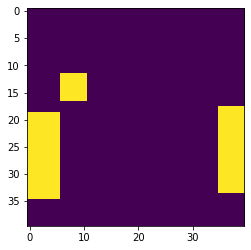

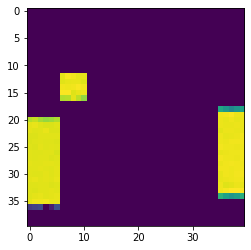

In [24]:
idx = 254
game_id = 100
plt.imshow(frames[game_id][idx])
plt.show()

pred_frames, pred_done = memory.net.predict([
    directions.reshape(-1, 1)[game_id:game_id+1],
    controls[:, 1:][game_id:game_id+1],
    encoded_frames[:, 1:][game_id:game_id+1]
])

pred_image = decoder(pred_frames[0][idx].reshape(1, -1))[0]
plt.imshow(pred_image)
plt.show()

In [25]:
def render_training_game():
    Renderer.init_window(1000, 500)

    for game_id in range(len(encoded_frames)):
        latent_frames, _ = memory.net.predict([
            directions.reshape(-1, 1)[game_id:game_id+1],
            controls[:, 1:][game_id:game_id+1],
            encoded_frames[:, 1:][game_id:game_id+1]
        ])
        pred_frames = decoder(latent_frames[0])
        split_screens = np.concatenate(
            (frames[game_id,1:], pred_frames), axis=2
        )

        n = mpl.colors.Normalize(vmin=0, vmax=1)
        split_screens = n(split_screens)
        split_screens = cm.bwr(1 - split_screens)

        for frame in split_screens:
            if not Renderer.can_render(): return
            if Renderer.key_pressed('r'): break
            Renderer.show_frame(frame)

render_training_game()

In [27]:
def render_actual_game():
    stateful = memory.copy_in_stateful_model()
    Renderer.init_window(500, 500)
    f = 0

    while True:
        stateful.init(random.uniform(0, 2 * math.pi))

        def step(user_input):
            pref_frame, done = stateful.step(user_input)
            return decoder.predict(pref_frame)[0], done

        while True:
            f += 1

            controls = [
                math.copysign(1, math.sin(f / 16)),
                math.copysign(1, math.sin(f / 20 + 1.2))
            ]
            frame, done = step(controls)
            done = done[0][0]
            frame = np.concatenate((
                frame,
                np.array([[done] * frame.shape[0]] * 3)
            ), axis=0)
            
            if done > 0.8:
                break

            if not Renderer.can_render(): return
            if Renderer.key_pressed('r'): break
            Renderer.show_frame(cm.bwr(1 - frame))

render_actual_game()